In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
from support.omniwheel_calculation_pd import *
from support.pd_support import *
from support.calculations_support import *
from support.ar_calculations import *
from support.imu_calculations import *
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import integrate

In [2]:
_txt_pth = r"test_data\omni_9dof_april_3_2023\orange_2500_april_3_2023_t1\imu01.csv"
_mocap_pth = r"test_data\omni_9dof_april_3_2023\orange\orange_2500_april_3_2023_t1.csv"

In [3]:
_base_pth = os.path.dirname(os.getcwd())
_base_pth = os.path.join(_base_pth,"ipy_notebooks", "test_data")
_parent_folder = "omni_9dof_april_10_2023"
_folder_name = "sk31_00_rotation_slow_03"
_pth = os.path.join(_base_pth,_parent_folder ,_folder_name)
_txt_pth = os.path.join(_pth, "imu01.csv")
_mocap_pth = os.path.join(os.path.join(_base_pth, _parent_folder), _folder_name.split("_")[0], _folder_name+ ".csv")

In [4]:
sk_df = pd.read_csv(_txt_pth)
_mocap_df, st_time = read_rigid_body_csv(_mocap_pth)
_mocap_df = add_datetime_col(_mocap_df, st_time, "seconds")

# type in marker details
_xm = get_rb_marker_name(4)
_zm = get_rb_marker_name(3)
_om = get_rb_marker_name(1)

"""set zero"""

sk_df = set_zero(sk_df, column_name = ["e_fr"])

sk_df["rust_time"] = sk_df["rust_time"].apply(lambda x: datetime.fromtimestamp(x))
sk_df.rename(columns={"rust_time": "time", "e_fr":"enc"}, inplace=True)

In [5]:
_mocap_df.seconds.diff().min()

0.00999999999999801

In [6]:
"""getting angle from non-syncronized data from skateboard df"""
sk_df["ang_y"] = sk_df["enc"].apply(lambda x: x*0.036)
sk_df["diff"] = abs(sk_df["ang_y"].diff())
# replace nan with 0
sk_df["diff"].fillna(0, inplace=True)

# change micros to seconds
# sk_df["seconds"] = sk_df["micros"] / 1000000

# integrate angle
_myval = sk_df["diff"].cumsum()
_new_ang_df, _ = get_orientation(sk_df, "ang_y")
_new_ang_df

,sys_time,time,enc,ang_y,diff,theta
0,2023-04-10 10:40:56.147734,2023-04-10 10:40:56.148060,0,0.000,0.0,0.00000
1,2023-04-10 10:40:56.307414,2023-04-10 10:40:56.307411,0,0.000,0.0,0.00000
2,2023-04-10 10:40:56.307414,2023-04-10 10:40:56.307720,0,0.000,0.0,0.00000
3,2023-04-10 10:40:56.307886,2023-04-10 10:40:56.308016,0,0.000,0.0,0.00000
4,2023-04-10 10:40:56.307886,2023-04-10 10:40:56.308292,0,0.000,0.0,0.00000
...,...,...,...,...,...,...
5247,2023-04-10 10:41:48.626414,2023-04-10 10:41:48.626711,159524,5742.864,0.0,302575.66992
5248,2023-04-10 10:41:48.636639,2023-04-10 10:41:48.636674,159524,5742.864,0.0,302690.52720
5249,2023-04-10 10:41:48.646552,2023-04-10 10:41:48.646662,159524,5742.864,0.0,302805.38448
5250,2023-04-10 10:41:48.656323,2023-04-10 10:41:48.656731,159524,5742.864,0.0,302920.24176


In [7]:
# This cell is optimized to run faster using polars

# calculate rotation matrix from xvec, zvec, org
_m_df = _mocap_df.copy()

# _m_df[_om["y"]] = savgol_filter(_m_df[_om["y"]], 11, 1)
# _m_df[_xm["y"]] = savgol_filter(_m_df[_xm["y"]], 11, 1)
# _m_df[_zm["y"]] = savgol_filter(_m_df[_zm["y"]], 11, 1)

_m_df = pl.from_pandas(_m_df)

_rotmat_i = []
for i in tqdm(range(len(_m_df))):
    
    _x_vec = _m_df[[_xm["x"], _xm["y"], _xm["z"]]][i, :].to_numpy().T
    _z_vec = _m_df[[_zm["x"], _zm["y"], _zm["z"]]][i, :].to_numpy().T
    _org = _m_df[[_om["x"], _om["y"], _om["z"]]][i, :].to_numpy().T

    _rotmat_i.append(calculate_rotmat(_x_vec, _z_vec, _org))
# calculating del rotmat for mc
_del_r = []
for i in tqdm(range(len(_rotmat_i))):
    _del_r.append(_rotmat_i[i].T@_rotmat_i[0])

# calculating angle for mc
_theta_x = []
_theta_y = []
_theta_z = []

for i in tqdm(_del_r):
    _theta_x.append(np.arctan2(i[2,1], i[2,2]))
    _theta_y.append(np.arctan2(-i[2,0], np.sqrt(i[2,1]**2 + i[2,2]**2)))
    _theta_z.append(np.arctan2(i[1,0], i[0,0]))
    
_theta_x = np.array(_theta_x)
_theta_y = np.array(_theta_y)
_theta_z = np.array(_theta_z)

# converting them to degrees
_theta_x = np.rad2deg(_theta_x)
_theta_y = np.rad2deg(_theta_y)
_theta_z = np.rad2deg(_theta_z)

100%|██████████| 4772/4772 [00:00<00:00, 132808.82it/s]


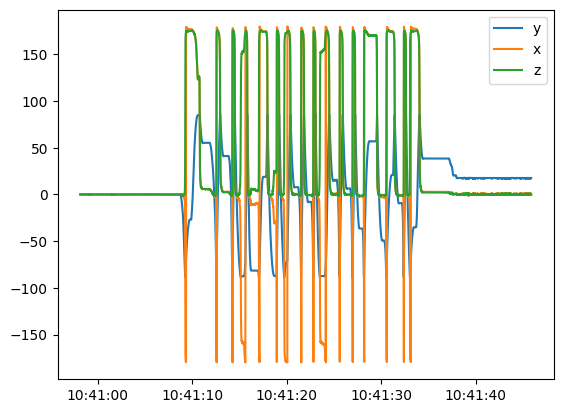

In [8]:
plt.plot(_m_df["time"], _theta_y, label="y")
plt.plot(_m_df["time"], _theta_x, label="x")
plt.plot(_m_df["time"], _theta_z, label="z")

plt.legend()

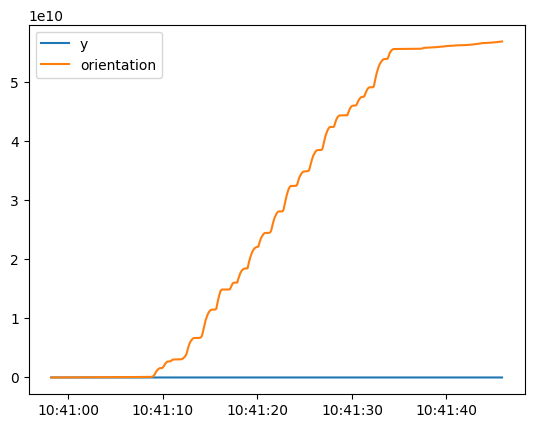

In [9]:
theta_df = pd.DataFrame({"time": _m_df["time"], "theta_y": _theta_y, "theta_x": _theta_x, "theta_z": _theta_z})
theta_df["diff"] = abs(theta_df["theta_y"].diff())
# theta_df["diff"] = theta_df["theta_y"].diff()
# replace nan with 0
theta_df["diff"].fillna(0, inplace=True)
# integrate angle
df, _ = get_orientation(theta_df, "diff")
mocap_orientation = integrate.cumtrapz(theta_df["diff"], theta_df.time, initial=0)
# mocap_orientation = theta_df["diff"].cumsum()*0.02

plt.plot(df["time"], df["theta"], label="y")
plt.plot(theta_df.time, mocap_orientation, label="orientation")
plt.legend()

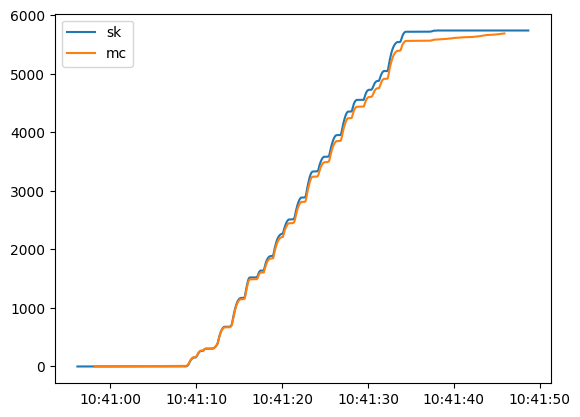

In [10]:
"""plot the angle from skateboard and mocap"""
plt.plot(_new_ang_df["time"], _new_ang_df["ang_y"], label="sk")
plt.plot(df["time"], df["theta"]*50, label="mc")
# plt.plot(theta_df.time, mocap_orientation/10000000, label="orientation")
plt.legend()

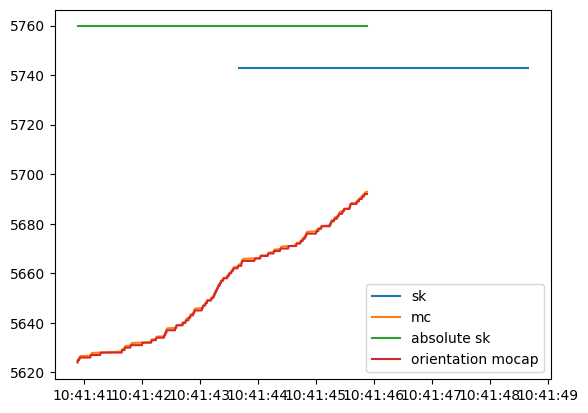

In [11]:
"""plot the angle from skateboard and mocap"""
plt.plot(_new_ang_df["time"][-500:], _new_ang_df["ang_y"][-500:], label="sk")
plt.plot(df["time"][-500:], df["theta"][-500:]*50, label="mc")
plt.plot(df["time"][-500:], _myval[-500:], label = "absolute sk")
plt.plot(theta_df.time[-500:], mocap_orientation[-500:]/10000000, label="orientation mocap")
plt.legend()

In [12]:
_myval.max() - df["theta"].max()*50

66.75468999806071